In [1]:
import math
import numpy as np
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot as plt
import torch
from torchvision.transforms import Lambda
from torch.utils.data import Dataset, DataLoader
from torch import nn
from tqdm import tqdm
import time
import os

In [2]:
class CTRDataset(Dataset):
    def __init__(self, data_path, feat_mapper=None, defaults=None,
                 min_threshold=4, num_feat=34,transform = None):
        self.NUM_FEATS, self.count, self.data = num_feat, 0, {}
        feat_cnts = defaultdict(lambda: defaultdict(int)) #记录第i个特征有几种embedding，每个embedding出现次数
        self.feat_mapper, self.defaults = feat_mapper, defaults
        self.field_dims = np.zeros(self.NUM_FEATS, dtype=np.int64)
        self.transform = transform
        with open(data_path) as f:
            for line in f:
                instance = {}
                values = line.rstrip('\n').split('\t')
                if len(values) != self.NUM_FEATS + 1:
                    continue
                label = np.float32([0, 0])
                label[int(values[0])] = 1
                instance['y'] = [np.float32(values[0])]
                for i in range(1, self.NUM_FEATS + 1):
                    feat_cnts[i][values[i]] += 1 #第i种feature的一种embedding的计数+1
                    instance.setdefault('x', []).append(values[i])
                self.data[self.count] = instance #{'y': [1.0], 'x': ['11417225884335159926',...,'631302449310544']}
                self.count = self.count + 1

        if self.feat_mapper is None and self.defaults is None:
            feat_mapper = {i: {feat for feat, c in cnt.items() if c >= min_threshold} for i, cnt in feat_cnts.items()}
            # 对feat_cnts的34种feature的每个embedding保存在feat_mapper，前提是其出现次数不小于min_threshold
            self.feat_mapper = {i: {feat_v: idx for idx, feat_v in enumerate(feat_values)}
                                for i, feat_values in feat_mapper.items()}
            # self.feat_mapper{key:1~34 ;value:DICT}，DICT{key:第i种feature的某个embedding；value:其在feat_mapper的第i个dict内的index 范围：[0,len(feat_mapper[i])]}
            self.defaults = {i: len(feat_values) for i, feat_values in feat_mapper.items()}
            #记录第i种feature有多少种embedding
        for i, fm in self.feat_mapper.items():
            self.field_dims[i - 1] = len(fm) +1 #留出空间给默认值
        self.offsets = np.array((0, *np.cumsum(self.field_dims)[:-1]))
        # 偏置 使每个embedding有不同的代码 offsets[i]==len(self.feat_mapper[i-1])+1
        # 第i个feature:[offsets[i],offsets[i]+len(self.feat_mapper[i])-1]
        # 第i-1个feature不存在的embedding:offsets[i-1]+len(self.feat_mapper[i-1])==offsets[i]-1
    def __len__(self):
        return self.count

    def __getitem__(self, idx):
        feat = np.array([self.feat_mapper[i + 1].get(v, self.defaults[i + 1]) #如果不存在则返回self.defaults[i + 1]
                         for i, v in enumerate(self.data[idx]['x'])])
        X = feat + self.offsets
        Y = self.data[idx]['y']
        if self.transform != None:
            X = self.transform(X)
            Y = self.transform(Y)
        return X,Y

In [3]:
class FM(nn.Module):
    def __init__(self, field_dims, num_factors):
        super(FM, self).__init__()
        num_inputs = int(sum(field_dims)) #34种特征，每种特征各有多少种类别的总和
        self.embedding = nn.Embedding(num_inputs, num_factors)
        self.fc = nn.Embedding(num_inputs, 1)
        self.linear_layer = nn.Linear(len(field_dims),1,bias=True)

    def forward(self, x):
        # x.shape  [b,34]
        # self.embedding(x).shape [b,34, 20]
        # torch.sum(self.embedding(x), dim=1).shape [b,34]
        square_of_sum = torch.sum(self.embedding(x), dim=2) ** 2 #[b,34]
        sum_of_square = torch.sum(self.embedding(x) ** 2, dim=2) #[b,34]
        x = self.linear_layer(self.fc(x).sum(2)) + 0.5 * (square_of_sum - sum_of_square).sum(1,keepdims=True)
        x = torch.sigmoid(x)
        return x

In [4]:
batch_size = 2048
data_dir = '../../data/ctr'
transform = Lambda(lambda x: torch.tensor(x))
train_data = CTRDataset(os.path.join(data_dir, 'train.csv'),transform=transform)
test_data = CTRDataset(os.path.join(data_dir, 'test.csv'),
                           feat_mapper=train_data.feat_mapper,
                           defaults=train_data.defaults,transform=transform)
train_iter = DataLoader(
    train_data, shuffle=True, batch_size=batch_size)
test_iter = DataLoader(
    test_data, shuffle=False,  batch_size=batch_size)


net = FM(train_data.field_dims,20)

# print(net(torch.tensor(train_data.__getitem__(0)[0])))
optimizer = torch.optim.Adam(net.parameters(), lr=0.05)
loss = nn.BCELoss()
num_epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch+1))

In [5]:
def evaluate_accuracy(data_iter, net, device=None):
    """
    输出y为某个值时
    :param data_iter:
    :param net:
    :param device:
    :return:
    """
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            net.eval() # 评估模式, 这会关闭dropout
            acc_sum += (net(X.to(device)) == y.to(device)).sum().cpu().item()
            net.train() # 改回训练模式
            n += y.shape[0]
    return acc_sum / n

def train(net, train_iter, test_iter, optimizer,loss, device, num_epochs,oneHotEncoder=None,scheduler = None):
    net = net.to(device)
    print("training on ", device)
    plt_epoch = []
    plt_train_acc = []
    plt_test_acc = []
    for epoch in range(num_epochs):
        plt_epoch.append(epoch)
        train_l_sum, train_acc_sum, n, batch_count, start = 0.0, 0.0, 0, 0, time.time()
        for X, y in tqdm(train_iter):
            X = X.to(device)
            y_oneHot = y
            if oneHotEncoder:
                y_oneHot = torch.tensor(oneHotEncoder.transform(y).toarray())
            y = y.to(device)
            y_oneHot = y_oneHot.to(device)
            y_hat = net(X)
            l = loss(y_hat, y_oneHot)
            optimizer.zero_grad()
            l.backward()
            # grad_clipping(net, 1)
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat == y).sum().cpu().item()
            # print((y_hat == y).sum().cpu().item(),y.shape[0])
            n += y.shape[0] # batch_num
            batch_count += 1
            # print('train_acc_sum:',train_acc_sum,'n',n)
        if scheduler:
            scheduler.step()
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))
        plt_train_acc.append(train_acc_sum / n)
        plt_test_acc.append(test_acc)
    plt.plot(plt_epoch, plt_train_acc, color='r', label='train')  # r表示红色
    plt.plot(plt_epoch, plt_test_acc, color='b', label='test')  # 也可以用RGB值表示颜色
    plt.show()

training on  cuda


100%|██████████| 8/8 [00:02<00:00,  3.53it/s]


epoch 1, loss 43.5029, train acc 0.415, test acc 0.486, time 2.4 sec


100%|██████████| 8/8 [00:00<00:00, 13.25it/s]


epoch 2, loss 28.0268, train acc 0.451, test acc 0.450, time 0.7 sec


100%|██████████| 8/8 [00:00<00:00, 13.46it/s]


epoch 3, loss 17.8753, train acc 0.498, test acc 0.511, time 0.7 sec


100%|██████████| 8/8 [00:00<00:00, 12.62it/s]


epoch 4, loss 11.4310, train acc 0.543, test acc 0.558, time 0.7 sec


100%|██████████| 8/8 [00:00<00:00, 13.49it/s]


epoch 5, loss 7.2520, train acc 0.581, test acc 0.571, time 0.7 sec


100%|██████████| 8/8 [00:00<00:00, 12.66it/s]


epoch 6, loss 6.1243, train acc 0.583, test acc 0.570, time 0.7 sec


100%|██████████| 8/8 [00:00<00:00, 13.68it/s]


epoch 7, loss 4.9132, train acc 0.591, test acc 0.579, time 0.7 sec


100%|██████████| 8/8 [00:00<00:00, 13.44it/s]


epoch 8, loss 4.0786, train acc 0.597, test acc 0.578, time 0.7 sec


100%|██████████| 8/8 [00:00<00:00, 12.93it/s]


epoch 9, loss 3.8003, train acc 0.591, test acc 0.583, time 0.8 sec


100%|██████████| 8/8 [00:00<00:00, 13.35it/s]


epoch 10, loss 3.4755, train acc 0.596, test acc 0.579, time 0.7 sec


100%|██████████| 8/8 [00:00<00:00, 12.81it/s]


epoch 11, loss 3.3293, train acc 0.592, test acc 0.588, time 0.8 sec


100%|██████████| 8/8 [00:00<00:00, 12.25it/s]


epoch 12, loss 3.1504, train acc 0.593, test acc 0.577, time 0.8 sec


100%|██████████| 8/8 [00:00<00:00, 12.78it/s]


epoch 13, loss 2.9884, train acc 0.589, test acc 0.587, time 0.7 sec


100%|██████████| 8/8 [00:00<00:00, 11.94it/s]


epoch 14, loss 2.8533, train acc 0.592, test acc 0.581, time 0.8 sec


100%|██████████| 8/8 [00:00<00:00, 12.72it/s]


epoch 15, loss 2.6983, train acc 0.591, test acc 0.583, time 0.7 sec


100%|██████████| 8/8 [00:00<00:00, 11.96it/s]


epoch 16, loss 2.6702, train acc 0.590, test acc 0.583, time 0.8 sec


100%|██████████| 8/8 [00:00<00:00, 12.05it/s]


epoch 17, loss 2.4929, train acc 0.592, test acc 0.582, time 0.8 sec


100%|██████████| 8/8 [00:00<00:00, 10.39it/s]


epoch 18, loss 2.3973, train acc 0.590, test acc 0.584, time 0.9 sec


100%|██████████| 8/8 [00:00<00:00, 10.99it/s]


epoch 19, loss 2.3786, train acc 0.590, test acc 0.585, time 0.8 sec


100%|██████████| 8/8 [00:00<00:00, 11.22it/s]


epoch 20, loss 2.3170, train acc 0.593, test acc 0.583, time 0.8 sec


100%|██████████| 8/8 [00:00<00:00, 10.61it/s]


epoch 21, loss 2.2531, train acc 0.591, test acc 0.585, time 0.9 sec


100%|██████████| 8/8 [00:00<00:00, 11.88it/s]


epoch 22, loss 2.1089, train acc 0.593, test acc 0.583, time 0.8 sec


100%|██████████| 8/8 [00:00<00:00, 10.47it/s]


epoch 23, loss 2.1827, train acc 0.592, test acc 0.584, time 0.9 sec


100%|██████████| 8/8 [00:00<00:00, 10.90it/s]


epoch 24, loss 2.0639, train acc 0.591, test acc 0.587, time 0.9 sec


100%|██████████| 8/8 [00:00<00:00, 11.43it/s]


epoch 25, loss 2.0639, train acc 0.592, test acc 0.585, time 0.8 sec


100%|██████████| 8/8 [00:00<00:00, 10.44it/s]


epoch 26, loss 2.1011, train acc 0.592, test acc 0.585, time 0.9 sec


100%|██████████| 8/8 [00:00<00:00, 11.28it/s]


epoch 27, loss 1.9343, train acc 0.592, test acc 0.587, time 0.8 sec


100%|██████████| 8/8 [00:00<00:00, 10.70it/s]


epoch 28, loss 2.0367, train acc 0.592, test acc 0.588, time 0.9 sec


100%|██████████| 8/8 [00:00<00:00, 11.52it/s]


epoch 29, loss 1.9154, train acc 0.592, test acc 0.584, time 0.8 sec


100%|██████████| 8/8 [00:00<00:00, 11.62it/s]


epoch 30, loss 1.8808, train acc 0.592, test acc 0.587, time 0.9 sec


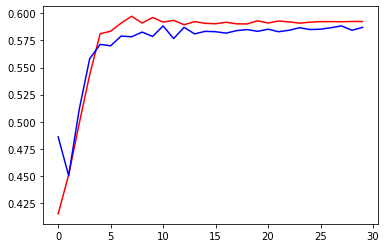

In [6]:
train(net, train_iter, test_iter, optimizer,loss, device, num_epochs,scheduler=scheduler)

In [7]:
df = pd.read_table('../../data/ctr/train.csv',sep = '\t',header = None)
print(len(df[df[0]==1])/len(df))

0.5016
